In [1]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
pb.pltutils.use_style()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def Kagome_lattice_hopping_more(d, t_a=-1,t_b=-1,t_nnn=0,v_a=0,v_b=0,v_c=0):
    a_cc = d
    a = a_cc*2
    lat = pb.Lattice(a1=[a*sqrt(3)/2, -a/2],
                     a2=[a*sqrt(3)/2, a/2])
    lat.add_sublattices(('A',[a*sqrt(3)/4,-a/4],v_a),('B',[a*sqrt(3)/4,a/4],v_b),('C', [0, 0],v_c))
    lat.add_hoppings(([0,0],'A','C',t_a),
                     ([1,0],'A','C',t_b),
                     ([0,0],'B','A',t_a),
                     ([-1,1],'B','A',t_b),
                     ([0,0],'C','B',t_a),
                     ([0,-1],'C','B',t_b),
                     ([1,0],'A','B',t_nnn),
                     ([1,0],'B','C',t_nnn),
                     ([0,1],'B','A',t_nnn),
                     ([0,1],'A','C',t_nnn),
                     ([-1,1],'C','A',t_nnn),
                     ([-1,1],'B','C',t_nnn),
                    )
    return lat




In [3]:
def Kagome_lattice_hopping_less(d, t=-1,v=0):
    a_cc = d # near-neighbor distance in the lattice
    a=a_cc*2
    lat = pb.Lattice(a1=[a*sqrt(3)/2, -a/2],
                     a2=[a*sqrt(3)/2, a/2])
    lat.add_sublattices(('A', [0, 0],v),('B',[a*sqrt(3)/4,-a/4],v),('C',[a*sqrt(3)/4,a/4],v))
    lat.add_hoppings(([0,0],'B','A',t),
                     ([1,0],'B','A',t),
                     ([0,0],'C','B',t),
                     ([-1,1],'C','B',t),
                     ([0,0],'A','C',t),
                     ([0,-1],'A','C',t),
                    )
    return lat


"""
Create minor ticks in the plot
# model = pb.Model(Kagome_lattice_2(d=1), pb.translational_symmetry(a1=True,a2=True))
# #model = pb.Model(Kagome_lattice(d=0.133), pb.primitive(a1=4,a2=4))

# #model.plot()

# plt.figure(figsize=(5, 5))
# model.plot(num_periods=2)

# # Customize the plot with minor grids
# plt.minorticks_on()
# plt.grid(which='both')  # Both major and minor grid lines
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# # Set the interval for minor grid lines to 0.1
# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
# plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))

# plt.show()
"""

"\nCreate minor ticks in the plot\n# model = pb.Model(Kagome_lattice_2(d=1), pb.translational_symmetry(a1=True,a2=True))\n# #model = pb.Model(Kagome_lattice(d=0.133), pb.primitive(a1=4,a2=4))\n\n# #model.plot()\n\n# plt.figure(figsize=(5, 5))\n# model.plot(num_periods=2)\n\n# # Customize the plot with minor grids\n# plt.minorticks_on()\n# plt.grid(which='both')  # Both major and minor grid lines\n# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')\n\n# # Set the interval for minor grid lines to 0.1\n# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))\n# plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))\n\n# plt.show()\n"

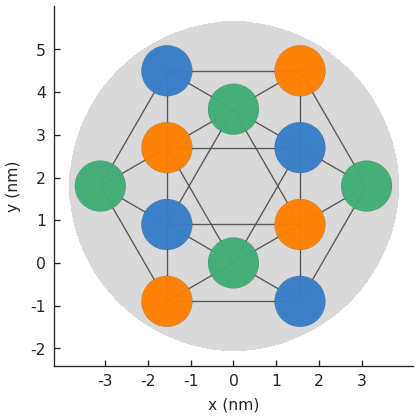

In [4]:
d = 1.8
shape = pb.circle(2*d + d/6, center=[0,d])
model = pb.Model(Kagome_lattice_hopping_more(d=d),shape)
model.plot()
shape.plot()

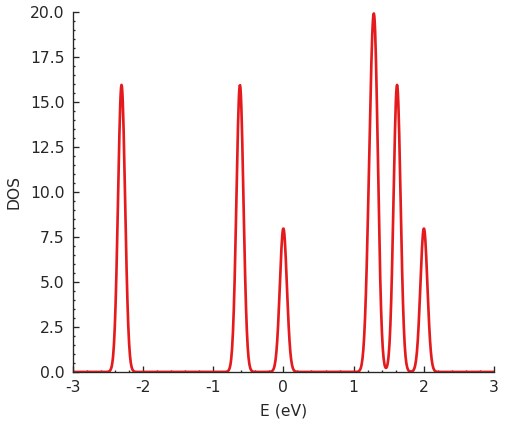

In [5]:
solver = pb.solver.lapack(model)
dos = solver.calc_dos(energies=np.linspace(-3, 3, 1000), broadening=0.05)
dos.plot()
plt.minorticks_on()

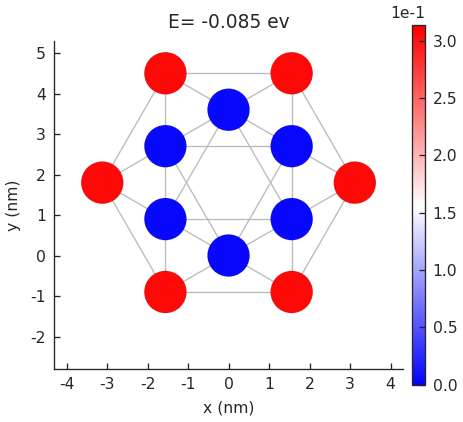

In [6]:

solver = pb.solver.lapack(model)
energy = -0.085
ldos_map = solver.calc_spatial_ldos(energy=energy, broadening=0.05)
plt.title("E= {} ev".format(energy))
ldos_map.plot(site_radius=0.4, cmap="bwr")
pb.pltutils.colorbar()


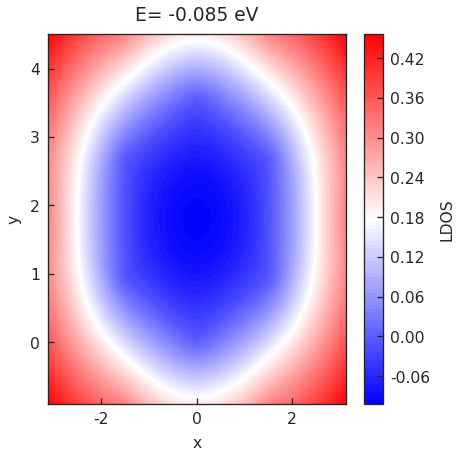

In [7]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from skimage.restoration import inpaint
from scipy.interpolate import Rbf
solver = pb.solver.lapack(model)
energy = -0.085
ldos_map = solver.calc_spatial_ldos(energy=energy, broadening=0.05)

#Extract the data from the map
x_coords = ldos_map.positions.x
y_coords = ldos_map.positions.y
ldos_values = ldos_map.data

# Create a grid covering the area of interest
x_min, x_max = x_coords.min(), x_coords.max()
y_min, y_max = y_coords.min(), y_coords.max()
x_grid, y_grid = np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)


# Interpolate LDOS values onto the grid using RBF interpolation
rbf = Rbf(x_coords, y_coords, ldos_values, function='linear')
ldos_grid = rbf(x_grid, y_grid)

"""
# Interpolate LDOS values onto the grid  using linear interpolation
#ldos_grid = griddata((x_coords, y_coords), ldos_values, (x_grid, y_grid), method='linear')
"""

# Handle NaN values: fill with nearest neighbor interpolation
ldos_grid_filled = np.where(np.isnan(ldos_grid), griddata((x_coords, y_coords), ldos_values, (x_grid, y_grid), method='nearest'), ldos_grid)

"""

# Inpaint NaN values using the 'nearest' method
# mask = np.isnan(ldos_grid)
# ldos_grid_filled = inpaint.inpaint_biharmonic(ldos_grid, mask)
"""

"""
# # Mask NaN values
# masked_ldos_grid = np.ma.masked_invalid(ldos_grid)


# # Apply Gaussian smoothing to the masked grid
# smoothed_ldos_grid = gaussian_filter(masked_ldos_grid.filled(0), sigma=1)
"""
# # Apply Gaussian filter to smooth the data

smoothed_ldos_grid = gaussian_filter(ldos_grid_filled, sigma=0.5)

# Plot the smoothed, interpolated LDOS map
plt.figure(figsize=(3, 3))
plt.contourf(x_grid, y_grid, smoothed_ldos_grid, levels=100, cmap='bwr')
plt.colorbar(label='LDOS')
plt.title(f"E= {energy} eV")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



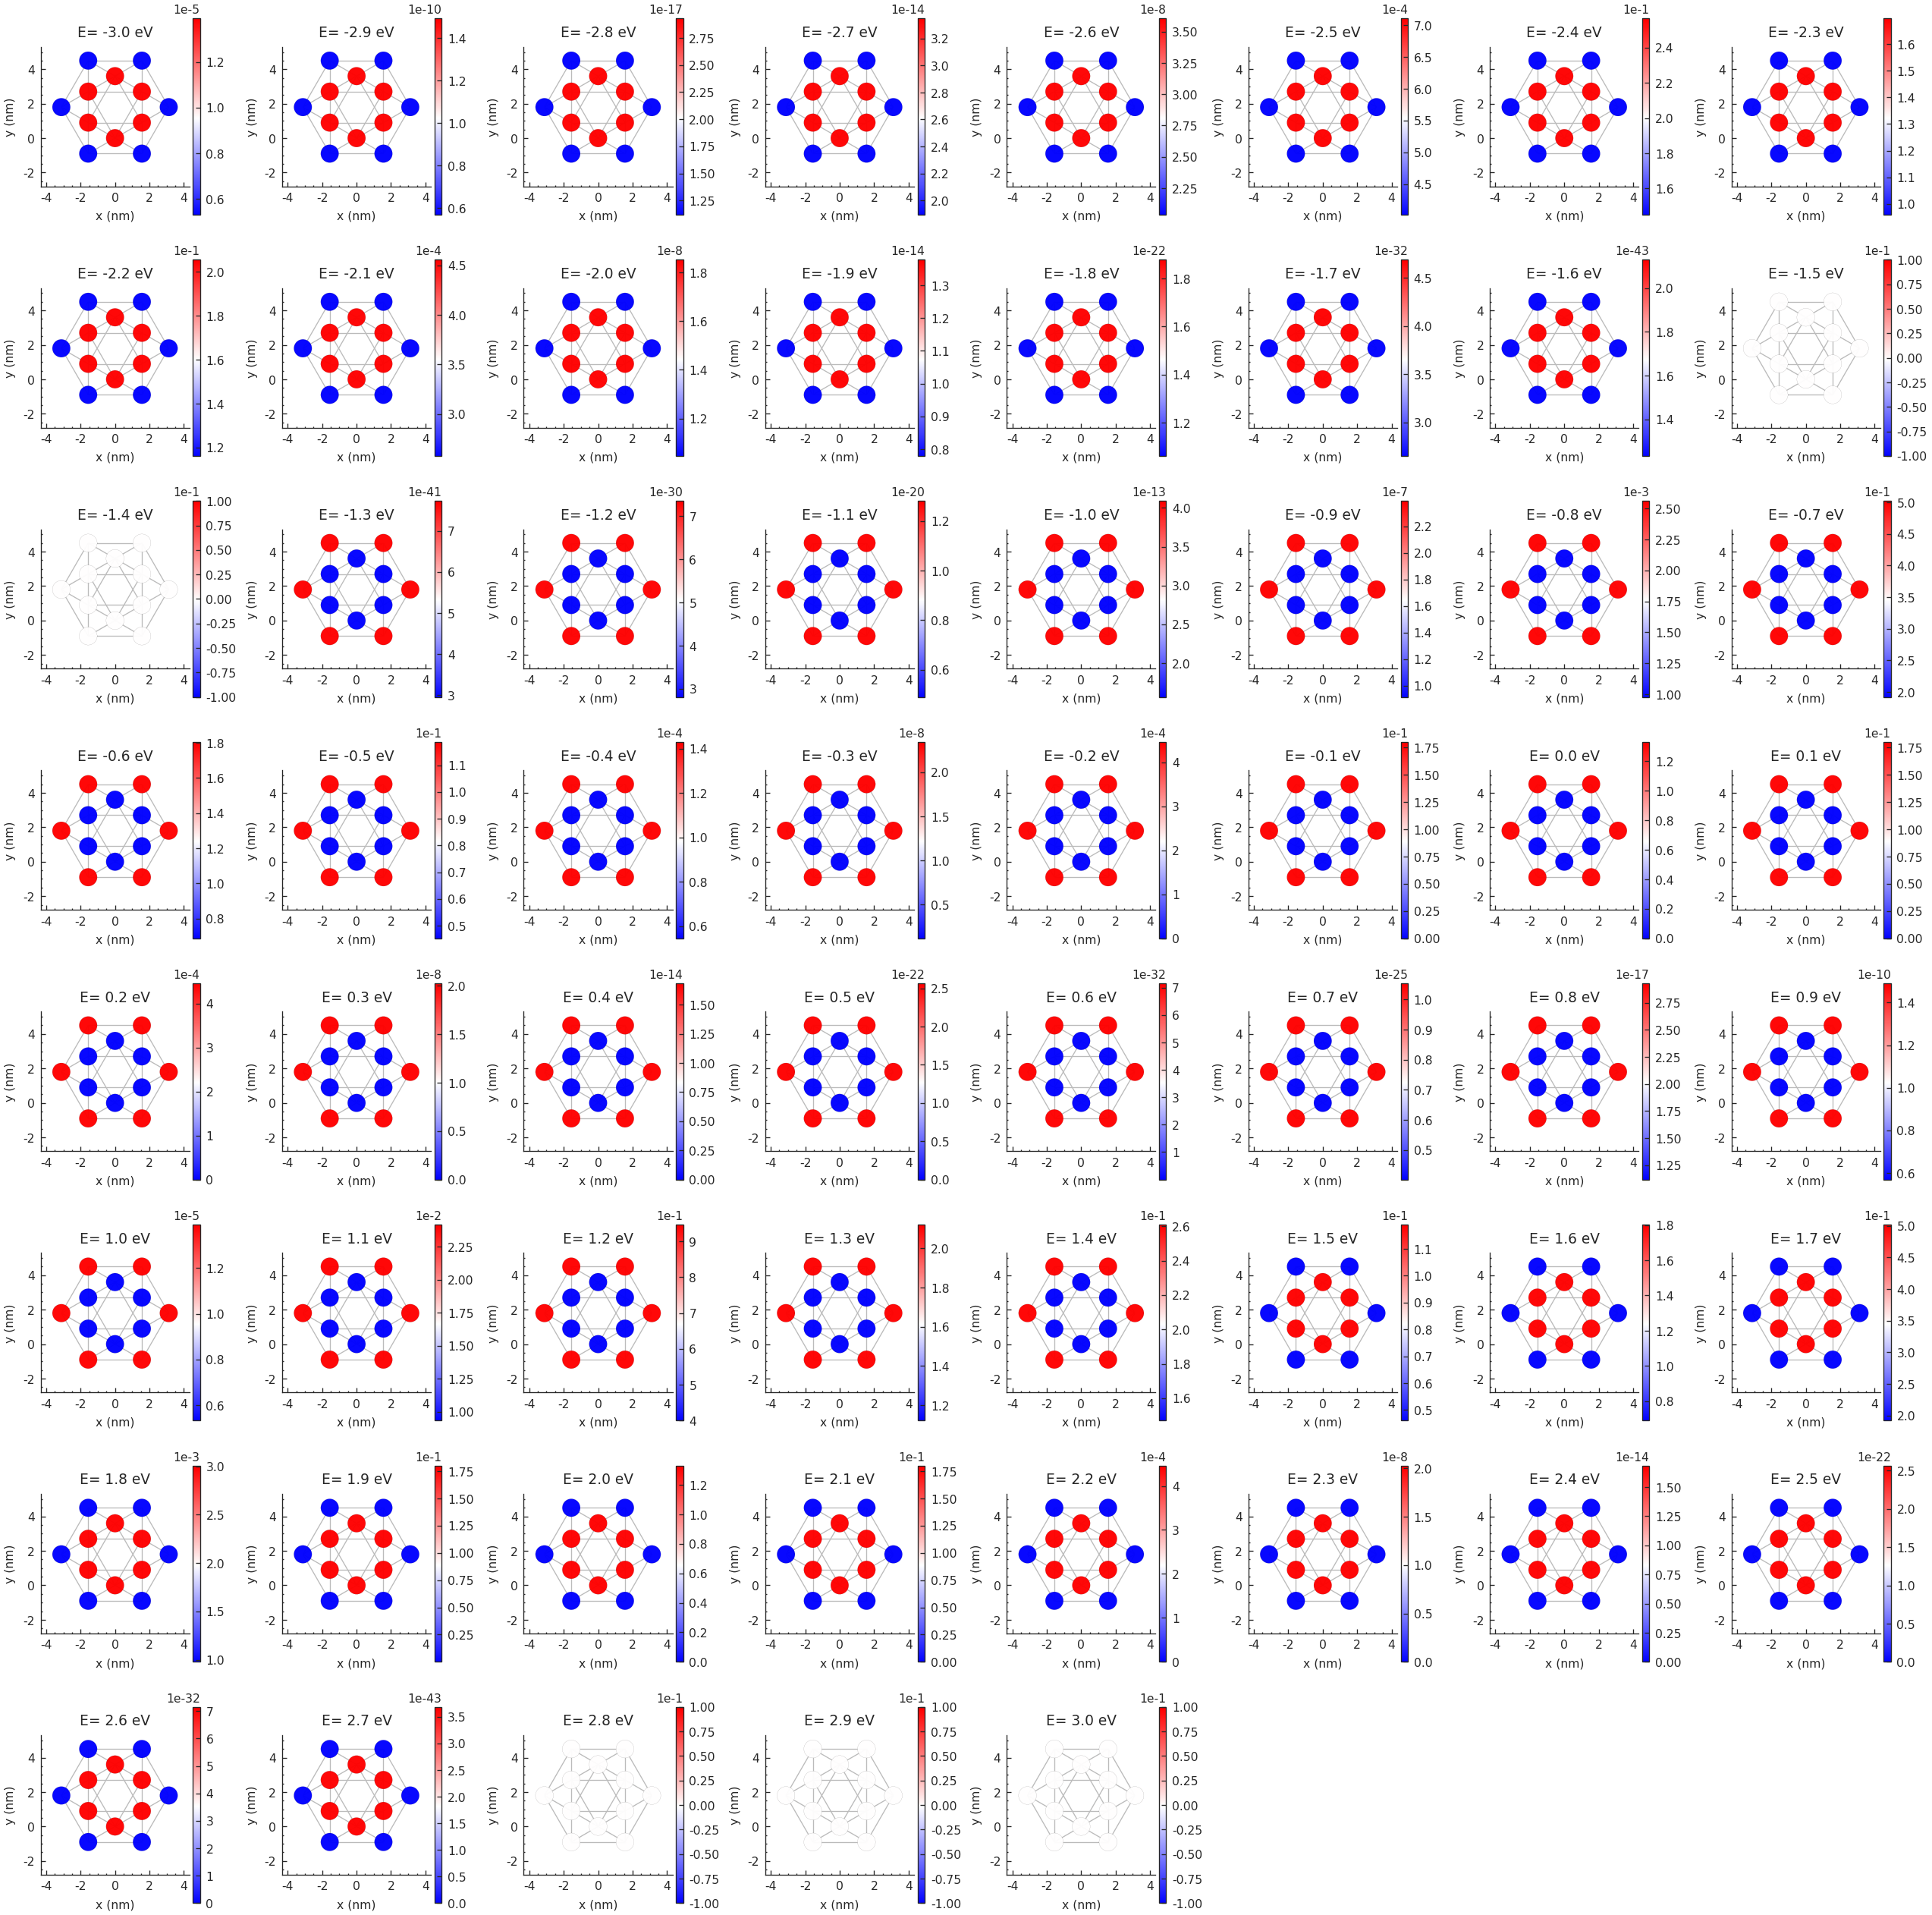

In [8]:
energies = np.arange(-3,3.1,0.1) 
plt.figure(figsize=(16, 16))
for i, energy in enumerate(energies):
    solver = pb.solver.lapack(model)
    ldos_map = solver.calc_spatial_ldos(energy=energy, broadening=0.05)
    ax = plt.subplot(8, 8, i + 1)
    ax.set_title("E= {:.1f} eV".format(energy))
    ldos_map.plot(site_radius=0.4, cmap="bwr")
    pb.pltutils.colorbar()
    ax.minorticks_on()
plt.tight_layout()
plt.show()

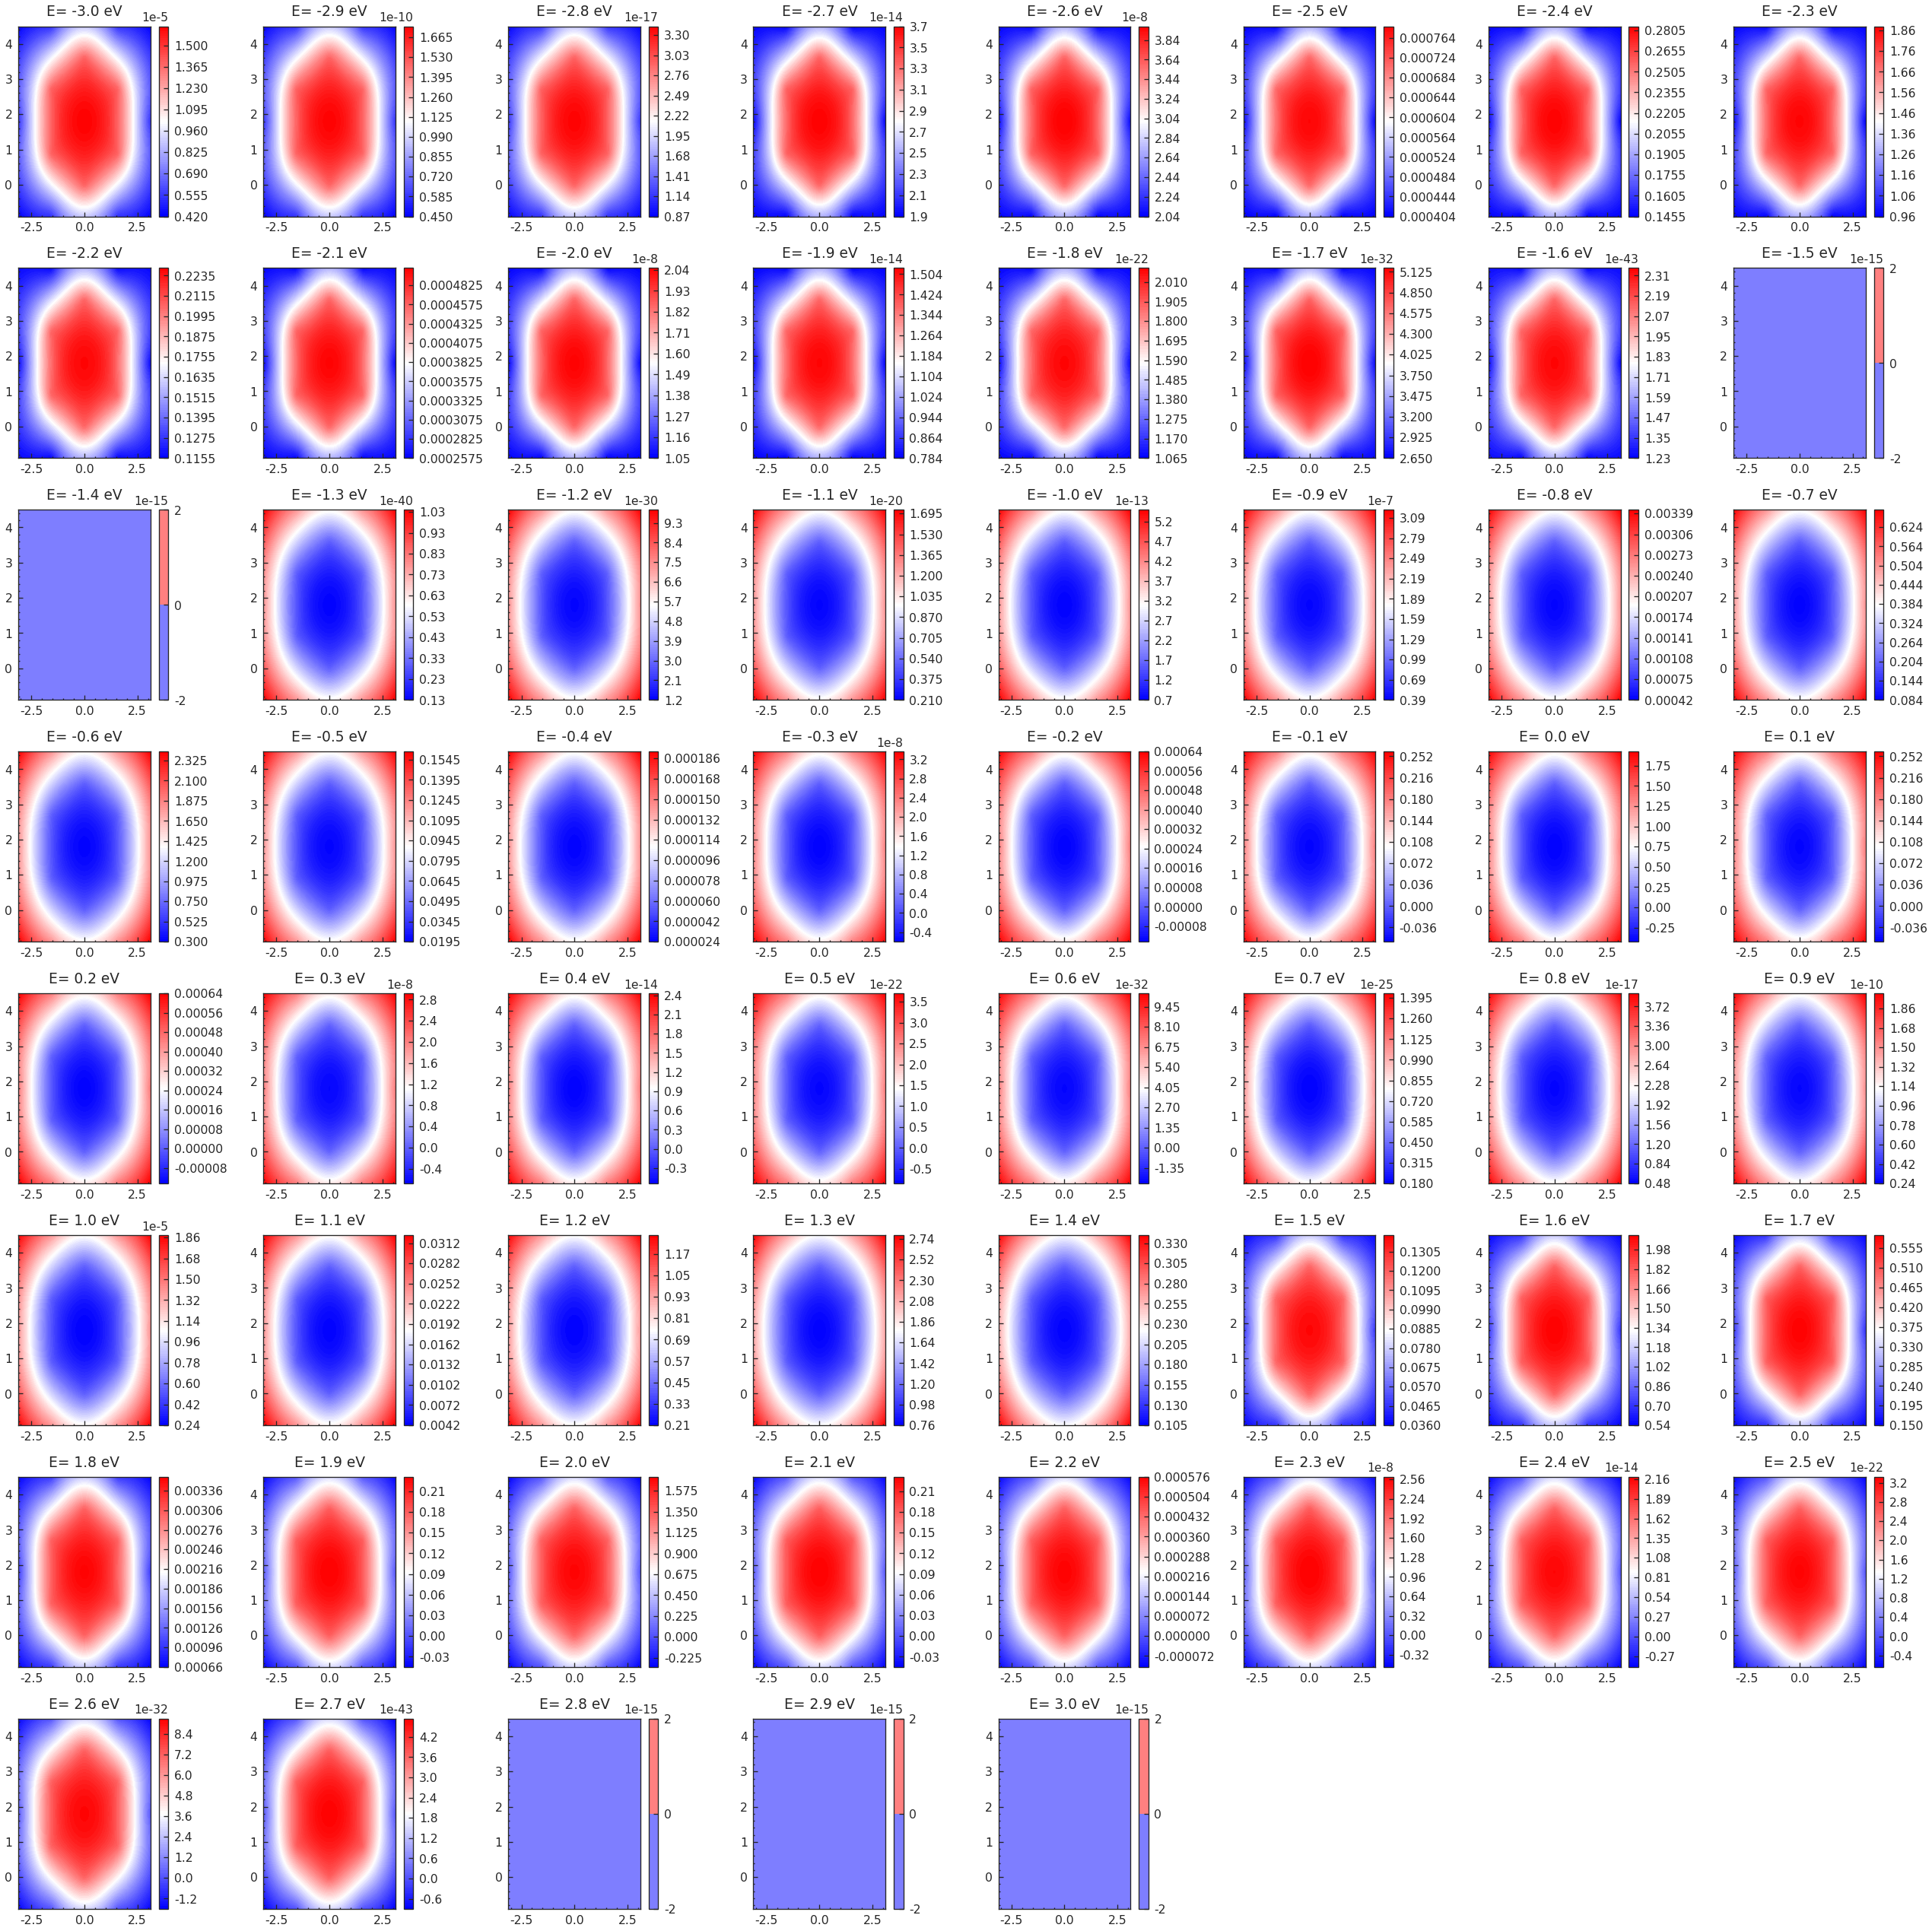

In [9]:
energies = np.arange(-3,3.1,0.1) 


plt.figure(figsize=(16, 16))
for i, energy in enumerate(energies):
    solver = pb.solver.lapack(model)
    ldos_map = solver.calc_spatial_ldos(energy=energy, broadening=0.05)

    #Extract the data from the map
    x_coords = ldos_map.positions.x
    y_coords = ldos_map.positions.y
    ldos_values = ldos_map.data

    # Create a grid covering the area of interest
    x_min, x_max = x_coords.min(), x_coords.max()
    y_min, y_max = y_coords.min(), y_coords.max()
    x_grid, y_grid = np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)
    x_grid, y_grid = np.meshgrid(x_grid, y_grid)

    # Interpolate LDOS values onto the grid using RBF interpolation
    rbf = Rbf(x_coords, y_coords, ldos_values, function='linear')
    ldos_grid = rbf(x_grid, y_grid)

    # Handle NaN values: fill with nearest neighbor interpolation
    ldos_grid_filled = np.where(np.isnan(ldos_grid), griddata((x_coords, y_coords), ldos_values, (x_grid, y_grid), method='nearest'), ldos_grid)

    #Apply Gaussian filter to smooth the data
    smoothed_ldos_grid = gaussian_filter(ldos_grid_filled, sigma=0.5)

    ax = plt.subplot(8, 8, i + 1)
    plt.contourf(x_grid, y_grid, smoothed_ldos_grid, levels=100, cmap='bwr')
    plt.colorbar()
    plt.title(f"E= {energy} eV")
    # plt.xlabel("x (nm)")
    # plt.ylabel("y (nm)")
    ax.set_title("E= {:.1f} eV".format(energy))
    ax.minorticks_on()
plt.tight_layout()
plt.show()

-3.617691993713379 3.617691993713379
-1.4000000953674316 4.999999523162842


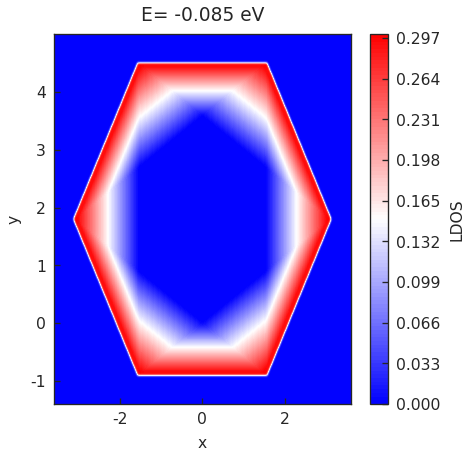

In [18]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from skimage.restoration import inpaint
from scipy.interpolate import Rbf
solver = pb.solver.lapack(model)
energy = -0.085
ldos_map = solver.calc_spatial_ldos(energy=energy, broadening=0.05)

#Extract the data from the map
x_coords = ldos_map.positions.x
y_coords = ldos_map.positions.y
ldos_values = ldos_map.data

# Create a grid covering the area of interest
x_min, x_max = x_coords.min(), x_coords.max()
y_min, y_max = y_coords.min(), y_coords.max()
x_min = x_min - .5
x_max = x_max + .5
y_min = y_min - .5
y_max = y_max + .5

print(x_min, x_max)
print(y_min, y_max)
x_grid, y_grid = np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)

# Initialize the LDOS grid with a very small value
# ldos_grid = np.full(x_grid.shape, 1e-200)

# # Define a distance threshold for "closeness"
# threshold_distance = 0.5  # Adjust this value as needed

# # Assign the LDOS values to the grid points that are close to x_coords and y_coords
# for x, y, value in zip(x_coords, y_coords, ldos_values):
#     distances = np.sqrt((x_grid - x) ** 2 + (y_grid - y) ** 2)
#     close_points = distances < threshold_distance
#     ldos_grid[close_points] = value

# Interpolate the LDOS values onto the grid
grid_points = np.array([x_coords, y_coords]).T
ldos_grid = griddata(grid_points, ldos_values, (x_grid, y_grid), method='linear', fill_value=1e-60)



# # Interpolate LDOS values onto the grid using RBF interpolation
# rbf = Rbf(x_coords, y_coords, ldos_values, function='linear')
# ldos_grid = rbf(x_grid, y_grid)

# """
# # Interpolate LDOS values onto the grid  using linear interpolation
# #ldos_grid = griddata((x_coords, y_coords), ldos_values, (x_grid, y_grid), method='linear')
# """

# # Handle NaN values: fill with nearest neighbor interpolation
# ldos_grid_filled = np.where(np.isnan(ldos_grid), griddata((x_coords, y_coords), ldos_values, (x_grid, y_grid), method='nearest'), ldos_grid)

"""

# Inpaint NaN values using the 'nearest' method
# mask = np.isnan(ldos_grid)
# ldos_grid_filled = inpaint.inpaint_biharmonic(ldos_grid, mask)
"""

"""
# # Mask NaN values
# masked_ldos_grid = np.ma.masked_invalid(ldos_grid)


# # Apply Gaussian smoothing to the masked grid
# smoothed_ldos_grid = gaussian_filter(masked_ldos_grid.filled(0), sigma=1)
"""
# # Apply Gaussian filter to smooth the data

smoothed_ldos_grid = gaussian_filter(ldos_grid, sigma=3)

# Plot the smoothed, interpolated LDOS map
plt.figure(figsize=(3, 3))
plt.contourf(x_grid, y_grid, smoothed_ldos_grid, levels=100, cmap='bwr')
plt.colorbar(label='LDOS')
plt.title(f"E= {energy} eV")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

